### **MOCK E-COMMERCE DATASET**
#### Practicing Basic SQL Queries, and both SQL and Pandas Data Aggregation, and Data GroupBy
#### **Libraries:** Pandas, Sqlite3, Matplotlib (for Data Viz)

In [35]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Dataset**

In [36]:
data = {
    'transaction_id': range(101, 121),
    'date': [
        '2024-01-15','2024-01-16','2024-01-20','2024-02-01','2024-02-05',
        '2024-02-10','2024-03-01','2024-03-05','2024-03-10','2024-03-12',
        '2024-01-15','2024-01-18','2024-02-20','2024-02-22','2024-03-15',
        '2024-03-18','2024-01-05','2024-02-14','2024-03-25','2024-03-30'
    ],
    'category': [
        'Electronics','Electronics','Clothing','Home','Electronics',
        'Clothing','Home','Electronics','Home','Clothing',
        'Electronics','Home','Clothing','Electronics','Home',
        'Clothing','Electronics','Home','Clothing','Electronics'
    ],
    'product': [
        'Laptop','Headphones','T-Shirt','Blender','Monitor',
        'Jeans','Sofa','Mouse','Lamp','Jacket',
        'Laptop','Table','Sneakers','Headphones','Rug',
        'Hat','Tablet','Chair','Scarf','Keyboard'
    ],
    'amount': [
        1200,150,25,80,300,
        50,500,40,60,120,
        1200,150,80,150,100,
        20,400,200,30,80
    ],
    'region': [
        'North','North','East','West','North',
        'East','West','South','West','East',
        'South','West','North','South','East',
        'East','North','South','West','South'
    ]
}

sql_df = pd.DataFrame(data)
sql_df = sql_df.values.tolist()

### Establish SQL Connection and Cursor

In [37]:
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

cursor.execute("""
    CREATE TABLE e_commerce(
        transaction_id INT PRIMARY KEY,
        date TEXT,
        category TEXT,
        product TEXT,
        amount INT,
        region TEXT
)               
""")

cursor.executemany('INSERT INTO e_commerce VALUES (?, ?, ?, ?, ?, ?)', sql_df)

In [38]:
def read_query(queries):
    return pd.read_sql_query(queries, conn)

sql_table = '''
    SELECT * FROM e_commerce
    LIMIT 5
'''

display(read_query(sql_table))

,transaction_id,date,category,product,amount,region
0,101,2024-01-15,Electronics,Laptop,1200,North
1,102,2024-01-16,Electronics,Headphones,150,North
2,103,2024-01-20,Clothing,T-Shirt,25,East
3,104,2024-02-01,Home,Blender,80,West
4,105,2024-02-05,Electronics,Monitor,300,North


### TRANSFROMING A DATAFRAME INTO A CSV FILE

In [39]:
pandas_df = pd.DataFrame(data)
pandas_df.head(5)

,transaction_id,date,category,product,amount,region
0,101,2024-01-15,Electronics,Laptop,1200,North
1,102,2024-01-16,Electronics,Headphones,150,North
2,103,2024-01-20,Clothing,T-Shirt,25,East
3,104,2024-02-01,Home,Blender,80,West
4,105,2024-02-05,Electronics,Monitor,300,North


In [40]:
pandas_df.to_csv('e-commerce.csv')

In [41]:
df2 = pd.read_csv('e-commerce.csv')
df2 = df2.drop(columns=['Unnamed: 0']) # dropping unnecessary column

df2.head(5)

,transaction_id,date,category,product,amount,region
0,101,2024-01-15,Electronics,Laptop,1200,North
1,102,2024-01-16,Electronics,Headphones,150,North
2,103,2024-01-20,Clothing,T-Shirt,25,East
3,104,2024-02-01,Home,Blender,80,West
4,105,2024-02-05,Electronics,Monitor,300,North


### **PROBLEM 1: Track The Total Sales**
#### Aggregate the following **amount** column using Pandas and SQL Query to calculate total revenue.

In [42]:
total_sales = """
    select sum(amount) from e_commerce
"""
display(read_query(total_sales))

,sum(amount)
0,4935


In [43]:
total_revenue= df2['amount'].sum()
print(f'Total Revenue from Sales: {total_revenue}')

Total Revenue from Sales: 4935


### **PROBLEM 2: Sales by Category**
#### Task: Group the dataset by category and compute:
- total sales
- average transaction amount
- number of transactions

In [44]:
sales = """
    select 
        category,
        round(avg(amount), 2) as transaction_amount,
        count(transaction_id) as num_of_transactions
    from e_commerce
    group by category
"""

display(read_query(sales))

,category,transaction_amount,num_of_transactions
0,Clothing,54.17,6
1,Electronics,440.00,8
2,Home,181.67,6


In [45]:
sales_by_category = df2.groupby('category').agg({'amount' : 'mean', 'transaction_id' : 'count'}).reset_index().round(2)
sales_by_category.rename(
    columns={'amount' : 'avg_transact_amount', 'transaction_id' : 'no_of_transactions'}
)
sales_by_category

,category,amount,transaction_id
0,Clothing,54.17,6
1,Electronics,440.00,8
2,Home,181.67,6


### **PROBLEM 3: Top 3 Highest-Spending Transactions**
#### Task: Display the top 3 transactions from diff. categories with the largest amount.

In [46]:
top_3 = """
    select 
        category,
        max(amount) as top_transactions
    from e_commerce
    group by category
    order by top_transactions desc
"""

display(read_query(top_3))

,category,top_transactions
0,Electronics,1200
1,Home,500
2,Clothing,120


In [47]:
top3 = df2.loc[df2.groupby('category')['amount'].idxmax()]

# unnecessary columns
top3 = top3.drop(columns=['transaction_id', 'date', 'product', 'region'])

# top transactions column & sorting values
top3 = top3.rename(columns={'amount' : 'top_transactions'}).sort_values(by='top_transactions', ascending=False)

top3

,category,top_transactions
0,Electronics,1200
6,Home,500
9,Clothing,120


### **PROBLEM 4: Sales by Region (Bar Chart)**
#### Task: Group by region and plot:
#### 📊 A bar chart of total sales per region.

In [48]:
cursor.execute("""
    alter table e_commerce
    rename column region to Region
""")

conn.commit()

sales_by_region = """
    select
        Region,
        sum(amount) as "Total Sales"
    from e_commerce
    group by Region
    order by "Total Sales" desc
"""
display(read_query(sales_by_region))

data_vis = read_query(sales_by_region)

,Region,Total Sales
0,North,2130
1,South,1670
2,West,820
3,East,315


C:\Users\LEI\AppData\Local\Temp\ipykernel_23868\1523955311.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Total Sales', data=data_vis, palette='pastel')


<Axes: title={'center': 'Sales Revenue per Region'}, xlabel='Region', ylabel='Total Sales'>

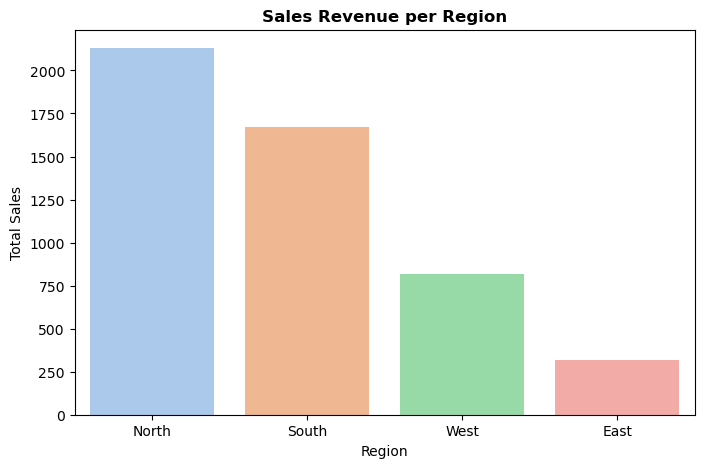

In [49]:
plt.figure(figsize=(8, 5))
plt.title('Sales Revenue per Region', fontweight='bold')
sns.barplot(x='Region', y='Total Sales', data=data_vis, palette='pastel')

In [50]:
from matplotlib import colormaps

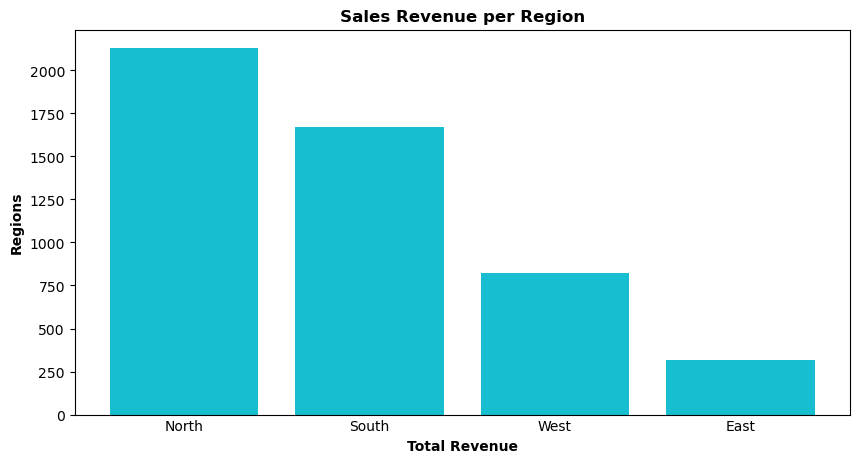

In [51]:
region_sales = df2.groupby('region').agg({'amount' : 'sum'}).reset_index().sort_values(by='amount', ascending=False)
region_sales = region_sales.rename(columns={'region' : 'Region', 'amount' : 'Total Sales'})

plt.figure(figsize=(10, 5))
plt.title('Sales Revenue per Region', fontweight='bold')
plt.bar(region_sales['Region'], region_sales['Total Sales'], color='C9')
plt.xlabel('Total Revenue', fontweight='bold')
plt.ylabel('Regions', fontweight='bold')
plt.tick_params(axis='x', length=0)

In [52]:
region_sales

,Region,Total Sales
1,North,2130
2,South,1670
3,West,820
0,East,315
